## Classification

In this notebook we will classify between spilled and not-spilled cup.

In [16]:
import torch
import torchvision
from PIL import Image
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

### Loading and preprocesing data
We are using a small data set containing 61 images almost equally distibuted among both classes.

In [7]:
data_dir = 'cup_data/'

In [8]:
# Transforms 
# TODO: use different transforms for train and test
transforms = transforms.Compose([transforms.Resize(224),
                                   transforms.CenterCrop(224),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

In [9]:
# Loading and applying transforms
data = datasets.ImageFolder(data_dir, transform=transforms)
class_names = data.classes
class_names

['nospill', 'spill']

**Split data into train and validation**

In [171]:
# split data in train and validaion
bs=4
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data, batch_size=bs, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(data, batch_size=bs,
                                                sampler=valid_sampler)

### Visulaize Images

Let's take a look at the images after transformation

In [172]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

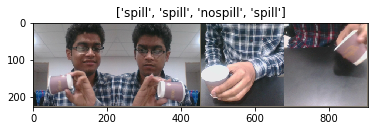

In [173]:
# get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])

### Model

We are going to use Transfer learning, because we have very small dataset.
We will use resnet18

In [174]:
model = models.densenet121(pretrained=True)

In [175]:
# Freeze model parameters, so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Change fc layers accoring to need
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

### Training

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device);

In [179]:
epochs = 2
steps = 0
running_loss = 0
print_every = 1


for epoch in range(epochs):
    steps += 1
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients to stop accumulation
        optimizer.zero_grad()
        
        # logits
        logps = model.forward(inputs)
        # labels
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validation_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validation_loader):.3f}")
            running_loss = 0
            model.train()
        

Epoch 1/2.. Train loss: 0.293.. Test loss: 0.225.. Test accuracy: 0.972
Epoch 1/2.. Train loss: 0.130.. Test loss: 0.231.. Test accuracy: 0.917
Epoch 1/2.. Train loss: 0.249.. Test loss: 0.209.. Test accuracy: 0.944
Epoch 1/2.. Train loss: 0.885.. Test loss: 0.205.. Test accuracy: 0.917
Epoch 1/2.. Train loss: 0.312.. Test loss: 0.179.. Test accuracy: 1.000
Epoch 1/2.. Train loss: 0.444.. Test loss: 0.212.. Test accuracy: 0.972
Epoch 1/2.. Train loss: 0.148.. Test loss: 0.186.. Test accuracy: 0.944
Epoch 1/2.. Train loss: 0.138.. Test loss: 0.200.. Test accuracy: 0.944
Epoch 1/2.. Train loss: 1.786.. Test loss: 0.203.. Test accuracy: 0.944
Epoch 1/2.. Train loss: 0.128.. Test loss: 0.179.. Test accuracy: 1.000
Epoch 1/2.. Train loss: 0.662.. Test loss: 0.197.. Test accuracy: 0.963
Epoch 1/2.. Train loss: 0.434.. Test loss: 0.198.. Test accuracy: 0.972
Epoch 1/2.. Train loss: 0.099.. Test loss: 0.168.. Test accuracy: 0.917
Epoch 1/2.. Train loss: 0.077.. Test loss: 0.196.. Test accuracy

### Inference

**Visualizing the model predictions**

*Generic function to display predictions for a few images*

In [188]:
def visualize_model(model, num_images=6):
    was_training = model.training  # maintain model state
    model.eval()
    images_so_far = 0
#     fig = plt.figure(figsize=(10,10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}  actual" {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

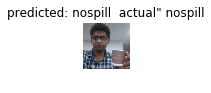

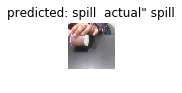

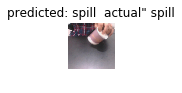

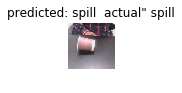

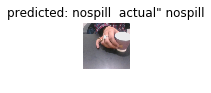

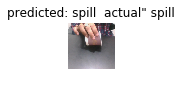

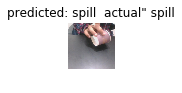

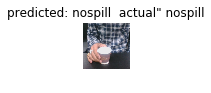

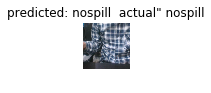

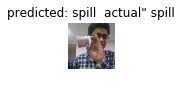

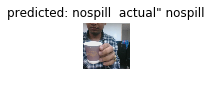

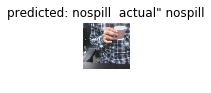

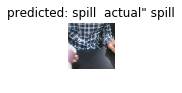

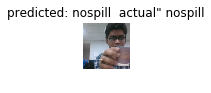

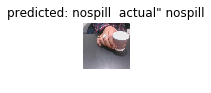

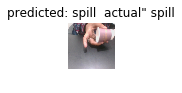

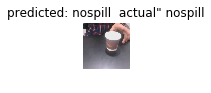

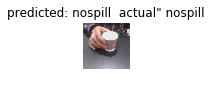

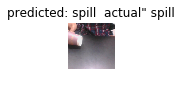

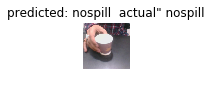

In [190]:
# BUG: Doesn't work when num_images is (bs*n+1); n >=0 and bs=batch size
visualize_model(model, num_images=20)

### Saving  the model

Seems like we have woking model, we are save it to use for future reference.

In [12]:
# saving model
SAVE_PATH = 'model/model_90_imgs.pth'
torch.save(model.state_dict(), SAVE_PATH)

NameError: name 'model' is not defined

### Loading the saved model

We are going to load the model from which we saved in previous step. 

For this we are going to write a function which will load the checkpoint and rebuild the model.

In [13]:
def load_ckpt(ckpt_path):
    ckpt = torch.load(ckpt_path)
    
    model = models.densenet121(pretrained=False)
    for param in model.parameters():
        param.requires_grad = False

    # Put the classifier on the pretrained network
    model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    model.load_state_dict(ckpt, strict=False)

    return model

In [14]:
# load model
model = load_ckpt(SAVE_PATH)

## Inference on custom images

Now time has came to check model accuracy on images of our own.

In [17]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

In [18]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = Image.open(image)
    return test_transforms(im)

In [19]:
img_path = 'test_data/2019-06-21-171638.jpg'
img_pros = process_image(img_path)

In [20]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

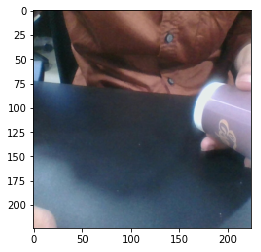

In [21]:
imshow(img_pros)

### Prediction

After preprocessing we are going to predict the class for the image

In [22]:
def predict(image_path, model):
    # Predict the class (or classes) of an image using a trained deep learning model.
    model.eval()
    img_pros = process_image(image_path)
    img_pros = img_pros.view(1,3,224,224)
    with torch.no_grad():
        output = model(img_pros)
    # probability of each classs
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    return top_p, class_names[top_class]

In [23]:
predict(img_path, model)

(tensor([[0.9806]]), 'spill')

In [149]:
img_path = 'test_data/2019-06-21-171638.jpg'
im = Image.open(img_path)
type(im)

PIL.JpegImagePlugin.JpegImageFile